# SILLM Tutorial 2

In this tutorial, we will do some basic old-fashioned NLP. Specifically:

- we will explore lemmas of words
- we will check out synsetsand how thesauri model word similarity
- we will look into a popular feature representations of text: the Bag-of-Words (BoW) representation
- we will train a text classifier
- we will evaluate the classifier
- we will do some language generation using language models

In [1]:
import nltk

NLTK, or Natural Language Toolkit, is a Python package that you can use for NLP.
https://www.nltk.org/

In [2]:
import pandas as pd

In [3]:
friends_data = pd.read_csv('FRIENDS.csv')
friends_data

,character,line
0,Monica,There's nothing to tell! He's just some guy I...
1,Joey,C'mon you're going out with the guy! There's...
2,Chandler,All right Joey be nice. So does he have a h...
3,Phoebe,Wait does he eat chalk?
4,Phoebe,Just 'cause I don't want her to go through ...
...,...,...
46509,Chandler,Oh it's gonna be okay.
46510,Rachel,Do you guys have to go to the new house righ...
46511,Monica,We got some time.
46512,Rachel,Okay should we get some coffee?


## 1. Let's get the lemma forms of some of these.

We will use wordnet for this. WordNet is a lexical database of semantic relations between words in more than 200 languages. WordNet links words into semantic relations including synonyms, hyponyms, and meronyms. More info: https://wordnet.princeton.edu/

Wordnet is integrated into NLTK.

In [4]:
# for tokenization
nltk.download('punkt')

#for lemmatization
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/dgarcia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/dgarcia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
# let's try this for the first 10 dialogues

sentences = friends_data.head(10)['line'].values
sentences

array([" There's nothing to tell! He's just some guy I work with!",
       " C'mon  you're going out with the guy! There's gotta be something wrong with him!",
       ' All right Joey  be nice.  So does he have a hump? A hump and a hairpiece?',
       ' Wait  does he eat chalk?',
       " Just  'cause  I don't want her to go through what I went through with Carl- oh!",
       " Okay  everybody relax. This is not even a date. It's just two people going out to dinner and- not having sex.",
       ' Sounds like a date to me.',
       " Alright  so I'm back in high school  I'm standing in the middle of the cafeteria  and I realize I am totally naked.",
       " Then I look down  and I realize there's a phone... there.",
       ' Instead of...?'], dtype=object)

In [6]:
lemmatizer = WordNetLemmatizer()

corpus_lemma = []

for sentence in sentences:
    tokenized = nltk.word_tokenize(sentence)
    lemmatized = [lemmatizer.lemmatize(word.lower()) for word in tokenized]
    if lemmatized != []:
        corpus_lemma.append(lemmatized)

Inspect the results. Is everything as expected?

In [7]:
sentences[6], corpus_lemma[6]

(' Sounds like a date to me.', ['sound', 'like', 'a', 'date', 'to', 'me', '.'])

In [8]:
sentences[2], corpus_lemma[2]

(' All right Joey  be nice.  So does he have a hump? A hump and a hairpiece?',
 ['all',
  'right',
  'joey',
  'be',
  'nice',
  '.',
  'so',
  'doe',
  'he',
  'have',
  'a',
  'hump',
  '?',
  'a',
  'hump',
  'and',
  'a',
  'hairpiece',
  '?'])

In [9]:
lemmatizer.lemmatize('does') # is this right?

'doe'

In [10]:
lemmatizer.lemmatize('singing')

'singing'

Lemmatization depends on the part-of-speech of what is being lemmatized. You can also use wordnet to troubleshoot: http://wordnetweb.princeton.edu/perl/webwn?s=singing&sub=Search+WordNet&o2=&o0=1&o8=1&o1=1&o7=&o5=&o9=&o6=&o3=&o4=&h=00000

## 2. Now, let's look at some synsets from NLTK

Recall that WordNet is a lexical database of semantic relations between words that links words into semantic relations including synonyms, hyponyms, and meronyms. The synonyms are grouped into **synsets** with short definitions and usage examples.

According to WordNet, a synset or synonym set is defined as a set of one or more synonyms that are interchangeable in some context without changing the truth value of the proposition in which they are embedded.

In [11]:
from nltk.corpus import wordnet as wn

In [12]:
wn.synsets('dog')

[Synset('dog.n.01'),
 Synset('frump.n.01'),
 Synset('dog.n.03'),
 Synset('cad.n.01'),
 Synset('frank.n.02'),
 Synset('pawl.n.01'),
 Synset('andiron.n.01'),
 Synset('chase.v.01')]

In [13]:
wn.synsets('dog', pos=wn.VERB)

[Synset('chase.v.01')]

In [14]:
lemma_synsets = []
for lemmatized in corpus_lemma:
  lemma_synset = [wn.synsets(lemma) for lemma in lemmatized]
  lemma_synsets.append(lemma_synset)

In [15]:
corpus_lemma[6][3], lemma_synsets[6][3]

('date',
 [Synset('date.n.01'),
  Synset('date.n.02'),
  Synset('date.n.03'),
  Synset('date.n.04'),
  Synset('date.n.05'),
  Synset('date.n.06'),
  Synset('date.n.07'),
  Synset('date.n.08'),
  Synset('date.v.01'),
  Synset('date.v.02'),
  Synset('date.v.03'),
  Synset('go_steady.v.01'),
  Synset('date.v.05')])

In [16]:
corpus_lemma[2][4], lemma_synsets[2][4]

('nice',
 [Synset('nice.n.01'),
  Synset('nice.a.01'),
  Synset('decent.s.01'),
  Synset('nice.s.03'),
  Synset('dainty.s.04'),
  Synset('courteous.s.01')])

## 3. Let's create a bag-of-words representation

For this, we will use Scikit Learn, the standard Python Library for Machine Learning, at least for non-deep learning models. While DL models are much more popular now, Scikit Learn is still used for evaluation and splitting datasets.

For getting a Bag-of-Words (BoW) representation, we will use the Count Vectorizer: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer() # initialize the vectorizer

In [18]:
# get all the dialogues
sentences = friends_data['line'].values

# create the representation
vectorizer.fit(sentences)

CountVectorizer()

In [19]:
len(vectorizer.vocabulary_)

12844

In [20]:
vectorizer.vocabulary_['does']

3320

In [21]:
bag_of_words = vectorizer.transform(sentences)
bag_of_words.shape # why 46514?

(46514, 12844)

In [22]:
bag_of_words.toarray() # a lot of this empty

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## 4. Let's train a classifier to detect who says a particular dialogue using the BoW representation

Since this is a supervised problem, we need to split our data into training and test sets.

### Step 1: Build the BoW Representation

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
train, test = train_test_split(friends_data, test_size = 0.3)

In [25]:
X_train = train['line'].values
y_train = train['character'].values
X_test = test['line'].values
y_test = test['character'].values

In [26]:
vectorizer = CountVectorizer()
X_train_v = vectorizer.fit_transform(X_train)

**fit**: Learn a vocabulary dictionary of all tokens in the raw documents.

**transform**: Transform documents to document-term matrix.

In [27]:
X_test_v = vectorizer.transform(X_test) # why transform and not fit_transform?

Count Vectorizer has some other parameters such as whether it should consider case or not, whether it should remove stopwords or not.

One of the most important parameters for this use case is the ngram_range which determines which types of n-grams will be modeled.

### Step 2: Classify

We will use a Naive Bayes Classifier.

In [28]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB() # initialize the classifier

In [29]:
 # fit the classifier, i.e., learn the parameters
clf = gnb.fit(X_train_v.toarray(), y_train)

In [30]:
# predict the labels of the test set
y_pred = clf.predict(X_test_v.toarray())

Let's have a cursory look at the results

In [31]:
pd.DataFrame([X_test[:5], y_pred[:5], y_test[:5]]).T

,0,1,2
0,Yeah I guess. It's just parents after a cer...,Monica,Joey
1,Okay Phoebe y'know what? That-that’s it th...,Joey,Monica
2,No you didn’t get me!! It’s an electric dril...,Monica,Chandler
3,Chinadolor Bong come on we steal that TV Gu...,Ross,Monica
4,It might be kinda cool.,Monica,Monica


## 5. Evaluate how well the classifier is doing

Scikit Learn also has several implementations of other types of metrics

In [32]:
from sklearn.metrics import classification_report # good for computing these metrics

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Chandler       0.32      0.05      0.09      2334
        Joey       0.33      0.14      0.20      2239
      Monica       0.18      0.76      0.29      2274
      Phoebe       0.27      0.13      0.17      2077
      Rachel       0.23      0.14      0.17      2501
        Ross       0.33      0.06      0.10      2530

    accuracy                           0.21     13955
   macro avg       0.28      0.21      0.17     13955
weighted avg       0.28      0.21      0.17     13955



In [33]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[ 126,  174, 1575,  162,  229,   68],
       [  49,  316, 1456,  123,  230,   65],
       [  66,   94, 1737,  136,  197,   44],
       [  44,  102, 1403,  262,  216,   50],
       [  55,  120, 1808,  115,  340,   63],
       [  51,  162, 1747,  160,  266,  144]])

<Axes: >

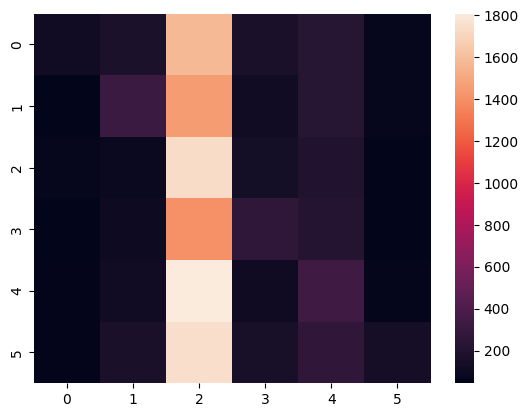

In [34]:
# you can also visualize this as a heatmap

import seaborn as sns
sns.heatmap(confusion_matrix(y_test, y_pred))

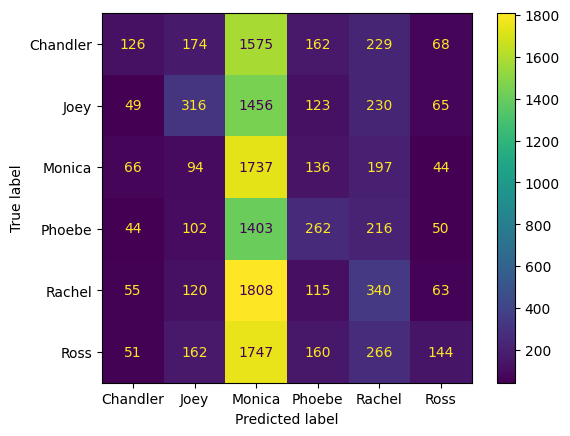

In [35]:
# or with sklearn directly
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_).plot()

## 6. Generate some dialogue ourselves.

Let's try to generate some sentences using our training data. For this task, we will use the language modeling module of nltk (detailed description: https://www.nltk.org/api/nltk.lm.html)

Build a unigram and a trigram language model using MLE. For each of the language models, generate a sentence of 7 words.

In [36]:
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE

In [37]:
# first tokenize the training set of dialogues
X_train_tokens = []
for sentence in X_train:
    tokenized = nltk.word_tokenize(sentence)
    X_train_tokens.append(tokenized)

In [38]:
# the padded_everygram_pipeline goes through the corpus, applies left and right padding to the sentences (adding <s> and </s>)
# and obtains the tuples of a given order together with the vocabulary
padded_tuples, vocab = padded_everygram_pipeline(1, X_train_tokens)
# generate (an empty) ngram language model for some n>0
lm_unigram = MLE(1)
# generate probabilities (model) given the list of n-grams and the vocabulary
lm_unigram.fit(padded_tuples, vocab)

padded_tuples, vocab = padded_everygram_pipeline(3, X_train_tokens)
lm_trigram = MLE(3)
lm_trigram.fit(padded_tuples, vocab)

In [40]:
print('Unigram sentence')
print(lm_unigram.generate(7))

print('Trigram sentence')
print(lm_trigram.generate(7))

Unigram sentence
['.', '!', 'with', 'don', 'I', 'relationships', 'gon']
Trigram sentence
['s', 'right', 'all', 'right', '.', '</s>', '</s>']


## Things to try on your own:

- a different type of representation (bigrams, trigrams, etc) [Note: might require more RAM than available in Colab/Kaggle. Try running on your local.]
- a different type of classifier (SVM, Logistic Regression, etc)
- a bigram and 4-gram model for generation